In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


In [3]:
# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Added color jittering
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
# Set directories for training and test datasets
train_dir = '/Users/tishyakasliwal/Real_AI_SD_LD_Dataset/train/Surrealism_'  
test_dir = '/Users/tishyakasliwal/Real_AI_SD_LD_Dataset/test/Surrealism_'      

In [8]:
# Debugging: Check if the directories exist
import os 
print("Train directory exists:", os.path.exists(train_dir))
print("Test directory exists:", os.path.exists(test_dir))

Train directory exists: True
Test directory exists: True


In [9]:
# Load datasets
train_dataset = ImageFolder(train_dir, transform=train_transforms)
test_dataset = ImageFolder(test_dir, transform=test_transforms)

In [10]:
# Print class mapping
print("Class to idx mapping:", train_dataset.class_to_idx)

Class to idx mapping: {'AI_LD_surrealism': 0, 'AI_SD_surrealism': 1, 'surrealism': 2}


In [11]:
# Create data loaders 
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


Displaying first batch of images:


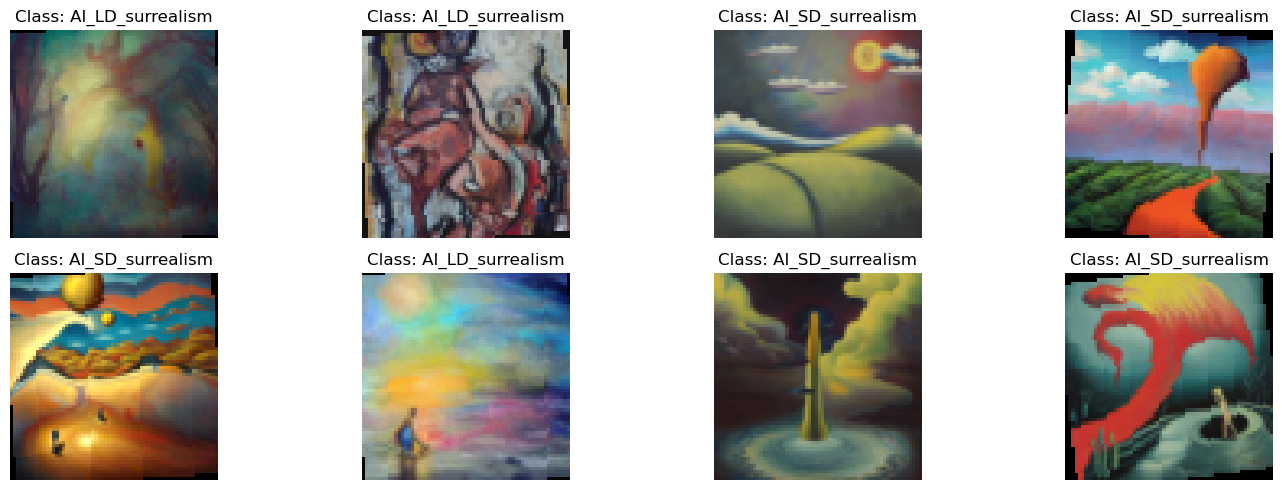

In [9]:
# Function to show images
def imshow_batch(images, labels, class_to_idx):
    plt.figure(figsize=(15, 5))
    
    # Create inverse mapping of class_to_idx
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    
    # Denormalize the images
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    images = images * std + mean  # denormalize
    images = torch.clamp(images, 0, 1)  # clamp to [0,1]
    
    # Show images
    for idx in range(min(8, len(images))):
        plt.subplot(2, 4, idx + 1)
        plt.imshow(images[idx].permute(1, 2, 0))
        plt.title(f'Class: {idx_to_class[labels[idx].item()]}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Get a batch of training data and show it
dataiter = iter(train_loader)
images, labels = next(dataiter)
print("\nDisplaying first batch of images:")
imshow_batch(images, labels, train_dataset.class_to_idx)

In [13]:
# Modified CNN architecture for 3-class classification
class UkiyoeCNN(nn.Module):
    def __init__(self, num_classes=3):  # Changed to 3 classes
        super(UkiyoeCNN, self).__init__()
        
        self.features = nn.Sequential(
            # First convolution block
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Second convolution block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Third convolution block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Dropout(0.25),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Fourth convolution block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Dropout(0.25),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)  # Output layer changed to 3 classes
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [11]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=20):
    best_acc = 0.0
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # Testing phase
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        class_correct = [0] * 3
        class_total = [0] * 3
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                # Per-class accuracy
                c = (predicted == labels).squeeze()
                for i in range(labels.size(0)):
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1
        
        test_loss = test_loss / len(test_loader)
        test_acc = 100. * correct / total
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        
        # Print per-class accuracy
        for i in range(3):
            if class_total[i] > 0:
                class_acc = 100 * class_correct[i] / class_total[i]
                print(f'Accuracy of class {i}: {class_acc:.2f}%')
        
        # Save best model
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), 'best_surrealism_classifier.pth')
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
        print(f'Best Test Acc: {best_acc:.2f}%')
        print('-' * 60)
    
    return train_losses, test_losses, train_accuracies, test_accuracies


In [12]:
# Initialize model, loss function, and optimizer
model = UkiyoeCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [13]:
# Train the model
train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs=10
)

Epoch 1/10:   0%|          | 0/493 [00:00<?, ?it/s]

Accuracy of class 0: 79.10%
Accuracy of class 1: 96.10%
Accuracy of class 2: 86.90%
Epoch 1/10:
Train Loss: 0.5394, Train Acc: 79.10%
Test Loss: 0.4274, Test Acc: 87.37%
Best Test Acc: 87.37%
------------------------------------------------------------


Epoch 2/10:   0%|          | 0/493 [00:00<?, ?it/s]

Accuracy of class 0: 79.20%
Accuracy of class 1: 92.30%
Accuracy of class 2: 93.20%
Epoch 2/10:
Train Loss: 0.3623, Train Acc: 86.16%
Test Loss: 0.4287, Test Acc: 88.23%
Best Test Acc: 88.23%
------------------------------------------------------------


Epoch 3/10:   0%|          | 0/493 [00:00<?, ?it/s]

Accuracy of class 0: 77.50%
Accuracy of class 1: 98.10%
Accuracy of class 2: 93.00%
Epoch 3/10:
Train Loss: 0.3102, Train Acc: 88.67%
Test Loss: 0.3974, Test Acc: 89.53%
Best Test Acc: 89.53%
------------------------------------------------------------


Epoch 4/10:   0%|          | 0/493 [00:00<?, ?it/s]

Accuracy of class 0: 76.60%
Accuracy of class 1: 91.90%
Accuracy of class 2: 91.60%
Epoch 4/10:
Train Loss: 0.2615, Train Acc: 90.28%
Test Loss: 0.8097, Test Acc: 86.70%
Best Test Acc: 89.53%
------------------------------------------------------------


Epoch 5/10:   0%|          | 0/493 [00:00<?, ?it/s]

Accuracy of class 0: 67.00%
Accuracy of class 1: 94.50%
Accuracy of class 2: 92.70%
Epoch 5/10:
Train Loss: 0.2420, Train Acc: 91.03%
Test Loss: 0.9636, Test Acc: 84.73%
Best Test Acc: 89.53%
------------------------------------------------------------


Epoch 6/10:   0%|          | 0/493 [00:00<?, ?it/s]

Accuracy of class 0: 76.70%
Accuracy of class 1: 99.10%
Accuracy of class 2: 93.20%
Epoch 6/10:
Train Loss: 0.2408, Train Acc: 91.53%
Test Loss: 0.3782, Test Acc: 89.67%
Best Test Acc: 89.67%
------------------------------------------------------------


Epoch 7/10:   0%|          | 0/493 [00:00<?, ?it/s]

Accuracy of class 0: 65.90%
Accuracy of class 1: 95.30%
Accuracy of class 2: 98.00%
Epoch 7/10:
Train Loss: 0.2406, Train Acc: 91.08%
Test Loss: 0.6685, Test Acc: 86.40%
Best Test Acc: 89.67%
------------------------------------------------------------


Epoch 8/10:   0%|          | 0/493 [00:00<?, ?it/s]

Accuracy of class 0: 74.60%
Accuracy of class 1: 95.60%
Accuracy of class 2: 96.80%
Epoch 8/10:
Train Loss: 0.2129, Train Acc: 92.12%
Test Loss: 0.9585, Test Acc: 89.00%
Best Test Acc: 89.67%
------------------------------------------------------------


Epoch 9/10:   0%|          | 0/493 [00:00<?, ?it/s]

Accuracy of class 0: 63.50%
Accuracy of class 1: 93.40%
Accuracy of class 2: 97.40%
Epoch 9/10:
Train Loss: 0.2052, Train Acc: 92.60%
Test Loss: 1.1877, Test Acc: 84.77%
Best Test Acc: 89.67%
------------------------------------------------------------


Epoch 10/10:   0%|          | 0/493 [00:00<?, ?it/s]

Accuracy of class 0: 76.90%
Accuracy of class 1: 98.30%
Accuracy of class 2: 97.80%
Epoch 10/10:
Train Loss: 0.1934, Train Acc: 92.98%
Test Loss: 0.4504, Test Acc: 91.00%
Best Test Acc: 91.00%
------------------------------------------------------------


In [ ]:
# Plot training and testing curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Testing Accuracy')

plt.tight_layout()
plt.show()

In [14]:
# Instantiate your model
model = UkiyoeCNN()

# Load the state dictionary into your model
model.load_state_dict(torch.load('best_surrealism_classifier.pth'))

# Set the model to evaluation mode if you are using it for inference
model.eval()

/var/folders/2z/ssqbf1vd32x1pypcmcgd5k5m0000gn/T/ipykernel_54937/3911014323.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_surrea

UkiyoeCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.25, inplace=False)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReL

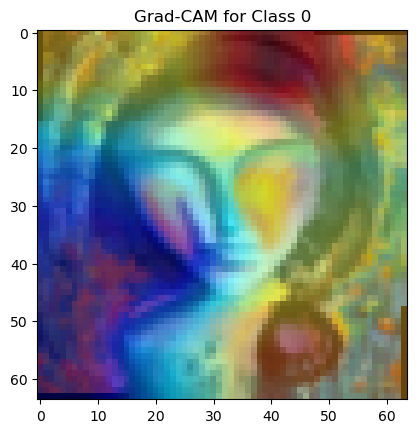

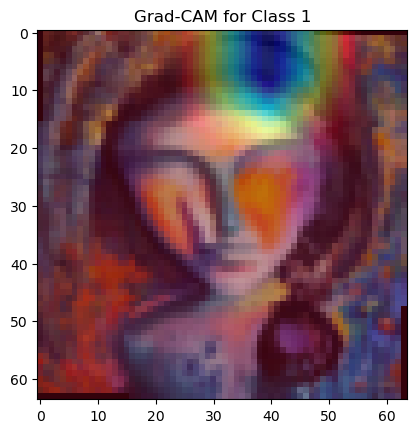

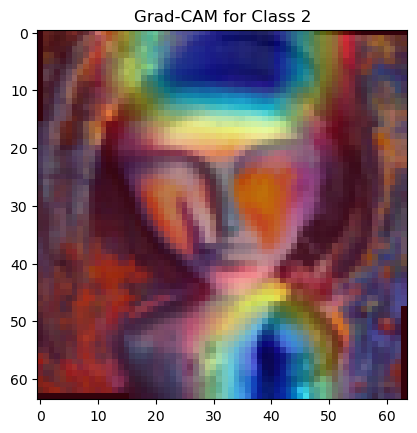

In [60]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

def grad_cam(model, input_image, target_class, target_layer):
    model.eval()
    
    # Forward pass
    activation = None
    gradients = None

    def save_activation(module, input, output):
        nonlocal activation
        activation = output.detach()

    def save_gradient(module, grad_input, grad_output):
        nonlocal gradients
        gradients = grad_output[0].detach()

    # Register hooks
    target_layer.register_forward_hook(save_activation)
    target_layer.register_backward_hook(save_gradient)
    
    # Forward and backward pass
    input_image = input_image.unsqueeze(0)  # Add batch dimension
    output = model(input_image)
    model.zero_grad()
    class_loss = output[0, target_class]
    class_loss.backward()
    
    # Grad-CAM calculations
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    for i in range(activation.shape[1]):
        activation[:, i, :, :] *= pooled_gradients[i]
    
    heatmap = torch.mean(activation, dim=1).squeeze().cpu().numpy()
    heatmap = np.maximum(heatmap, 0)  # ReLU
    heatmap /= np.max(heatmap)  # Normalize
    
    # Convert heatmap to original image size
    heatmap = cv2.resize(heatmap, (input_image.shape[2], input_image.shape[3]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Overlay heatmap on original image
    img = input_image.squeeze().permute(1, 2, 0).cpu().numpy()
    img = img - img.min()
    img = img / img.max()
    img = np.uint8(255 * img)
    overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    
    plt.imshow(overlay)
    plt.title(f"Grad-CAM for Class {target_class}")
    plt.show()

input_image, _ = train_dataset[1500]  # Example image
grad_cam(model, input_image, target_class=0, target_layer=model.features[17])
grad_cam(model, input_image, target_class=1, target_layer=model.features[17])
grad_cam(model, input_image, target_class=2, target_layer=model.features[17])


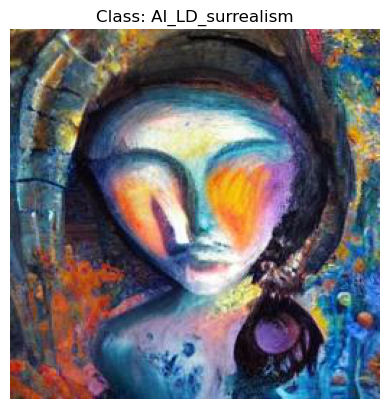

In [59]:
from PIL import Image
def show_raw_image(train_dir, dataset, idx):
    # Get the image path and corresponding label
    image_path, label = dataset.samples[idx]  # Accessing raw image path and label
    class_to_idx = dataset.class_to_idx
    idx_to_class = {v: k for k, v in class_to_idx.items()}  # Inverse mapping
    
    # Open the image using PIL
    raw_image = Image.open(image_path)
    
    # Display the image and its class
    plt.imshow(raw_image)
    plt.title(f"Class: {idx_to_class[label]}")
    plt.axis("off")
    plt.show()

# Example usage
show_raw_image(train_dir, train_dataset, idx=1500)